In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression
import matplotlib.pyplot as plt
import pickle
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sn
#from sklearn import datasets
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
import cv2
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint
from scipy.stats import norm
from openml import tasks, flows, runs, datasets, config
import random
from sklearn.pipeline import Pipeline
import pandasql as psql

df = pd.read_csv("dataset.csv", encoding = 'ISO-8859-1')
df.head(2)

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
0,2000-01-03,0,A 'hindrance to operations': extracts from the...,Scorecard,Hughes' instant hit buoys Blues,Jack gets his skates on at ice-cold Alex,Chaos as Maracana builds up for United,Depleted Leicester prevail as Elliott spoils E...,Hungry Spurs sense rich pickings,Gunners so wide of an easy target,...,Flintoff injury piles on woe for England,Hunters threaten Jospin with new battle of the...,Kohl's successor drawn into scandal,The difference between men and women,"Sara Denver, nurse turned solicitor",Diana's landmine crusade put Tories in a panic,Yeltsin's resignation caught opposition flat-f...,Russian roulette,Sold out,Recovering a title
1,2000-01-04,0,Scorecard,The best lake scene,Leader: German sleaze inquiry,"Cheerio, boyo",The main recommendations,Has Cubie killed fees?,Has Cubie killed fees?,Has Cubie killed fees?,...,On the critical list,The timing of their lives,Dear doctor,Irish court halts IRA man's extradition to Nor...,Burundi peace initiative fades after rebels re...,PE points the way forward to the ECB,Campaigners keep up pressure on Nazi war crime...,Jane Ratcliffe,Yet more things you wouldn't know without the ...,Millennium bug fails to bite


*Note: Here 'Label' is a binary attribute which consists 0 - Stock 
price goes down or stays the same, 1 - Stock price goes up.*

In [2]:
df.columns

Index(['Date', 'Label', 'Top1', 'Top2', 'Top3', 'Top4', 'Top5', 'Top6', 'Top7',
       'Top8', 'Top9', 'Top10', 'Top11', 'Top12', 'Top13', 'Top14', 'Top15',
       'Top16', 'Top17', 'Top18', 'Top19', 'Top20', 'Top21', 'Top22', 'Top23',
       'Top24', 'Top25'],
      dtype='object')

In [3]:
zero = df[df.Label==0]
one = df[df.Label==1]

In [4]:
len(zero), len(one)

(1935, 2166)

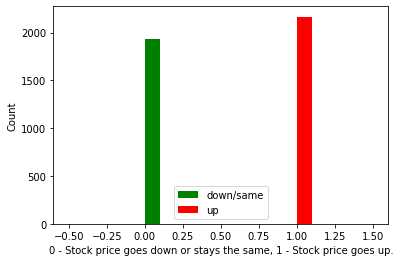

In [5]:
plt.hist(zero.Label, color="green", label="down/same")
plt.hist(one.Label, color="red", label="up")
plt.xlabel("0 - Stock price goes down or stays the same, 1 - Stock price goes up.")
plt.ylabel("Count")
plt.legend()

In [6]:
df.shape

(4101, 27)

In [7]:
df1 = df.dropna()

In [8]:
df2 = df1.drop(["Date"], axis="columns")

In [9]:
from nltk.tokenize import word_tokenize
import re
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from string import ascii_lowercase

stopWords = stopwords.words('english')

for c in ascii_lowercase:
    stopWords.append(c)

ps = PorterStemmer()

def fun(x):
    x = x.lower()
    x = re.sub(r"[^a-zA-Z]"," ", x)
    x = x.split()
    x = [ps.stem(i) for i in x if i not in stopWords]
    return x


def removeSpecialSymbol(df):
    for col in df.columns[1:]:
        df[col] = df[col].apply(lambda x: fun(x))
    return df

In [10]:
df3 = removeSpecialSymbol(df2)

In [11]:
df3[:1]

,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,...,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
0,0,"[hindranc, oper, extract, leak, report]",[scorecard],"[hugh, instant, hit, buoy, blue]","[jack, get, skate, ice, cold, alex]","[chao, maracana, build, unit]","[deplet, leicest, prevail, elliott, spoil, eve...","[hungri, spur, sens, rich, pick]","[gunner, wide, easi, target]","[derbi, rais, glass, strupar, debut, doubl]",...,"[flintoff, injuri, pile, woe, england]","[hunter, threaten, jospin, new, battl, somm]","[kohl, successor, drawn, scandal]","[differ, men, women]","[sara, denver, nurs, turn, solicitor]","[diana, landmin, crusad, put, tori, panic]","[yeltsin, resign, caught, opposit, flat, foot]","[russian, roulett]",[sold],"[recov, titl]"


In [12]:
all_data = []
all_words = []

for index, row in df3.iterrows():
    lst = []

    for col in df3.columns[1:]:
        for word in row[col]:
            lst.append(word)
            all_words.append(word)

    all_data.append((' '.join(lst), row["Label"]))

import random
random.shuffle(all_data)


In [13]:
from nltk import FreqDist
all_word_fre = FreqDist(all_words)

In [14]:
lmt = 10000

most_common = [i for i, j in  all_word_fre.most_common(lmt)]
most_common
    

['say',
 'us',
 'new',
 'year',
 'world',
 'kill',
 'govern',
 'china',
 'israel',
 'polic',
 'peopl',
 'attack',
 'countri',
 'protest',
 'report',
 'war',
 'call',
 'one',
 'state',
 'russia',
 'uk',
 'first',
 'right',
 'forc',
 'time',
 'ban',
 'use',
 'presid',
 'day',
 'leader',
 'get',
 'isra',
 'back',
 'review',
 'plan',
 'iran',
 'man',
 'two',
 'face',
 'take',
 'death',
 'russian',
 'north',
 'make',
 'bank',
 'law',
 'news',
 'may',
 'minist',
 'unit',
 'court',
 'nation',
 'korea',
 'citi',
 'warn',
 'said',
 'offici',
 'million',
 'could',
 'old',
 'british',
 'militari',
 'drug',
 'show',
 'arrest',
 'south',
 'un',
 'women',
 'go',
 'india',
 'found',
 'nuclear',
 'power',
 'want',
 'claim',
 'fire',
 'london',
 'england',
 'end',
 'human',
 'palestinian',
 'footbal',
 'home',
 'chines',
 'iraq',
 'live',
 'letter',
 'like',
 'hit',
 'top',
 'syria',
 'group',
 'amp',
 'set',
 'oil',
 'last',
 'children',
 'gaza',
 'rule',
 'strike',
 'die',
 'anti',
 'help',
 'charg',

In [15]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(max_features=lmt)
vectorizer.fit([' '.join(most_common)])

CountVectorizer(max_features=10000)

In [16]:
newDf = pd.DataFrame()
newDf[["headline", "Label"]] = all_data
newDf.head()

,headline,Label
0,australian govern grab million idl household b...,0
1,interview tahir abba student art keep parent h...,0
2,report isi fighter die eat poison iftar meal h...,1
3,see palin reddit polic car travel mph mph zone...,1
4,cypru presid famili transfer ten million londo...,0


In [17]:
X = newDf.drop(["Label"], axis="columns")
y = newDf["Label"].apply(lambda x: int(x))

X = vectorizer.transform(X.headline).toarray()

In [18]:
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
# x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.2,stratify=y)

In [19]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='minority')
x_train, y_train = smote.fit_resample(x_train, y_train)

In [20]:
x_train.shape

(3452, 9999)

In [21]:
y_train.value_counts()

0    1726
1    1726
Name: Label, dtype: int64

In [22]:
y_test.value_counts()

1    437
0    383
Name: Label, dtype: int64

In [30]:
import tensorflow as tf
from tensorflow import keras

model = keras.Sequential([
    keras.layers.Dense(100, input_shape=(x_train.shape[1], ), activation="relu"), # making hidden layer
    keras.layers.Dropout(0.2),
    keras.layers.Dense(10, activation="relu"), # making hidden layer
    # keras.layers.Dropout(0.2),
    # keras.layers.Dense(10, activation="relu"), # making hidden layer
    # keras.layers.Dense(2, activation="relu"), # making hidden layer
    keras.layers.Dense(1, activation="sigmoid"), # making output layer
])

model.compile(
    optimizer="adam", 
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

# tb_callback = tf.keras.callbacks.TensorBoard(log_dir="logs/", histogram_freq=1)
model.fit(x_train, y_train, epochs=5)

Epoch 1/5
108/108 [==============================] - 2s 13ms/step - loss: 0.6944 - accuracy: 0.5162
Epoch 2/5
108/108 [==============================] - 1s 12ms/step - loss: 0.6107 - accuracy: 0.6874
Epoch 3/5
108/108 [==============================] - 1s 14ms/step - loss: 0.3326 - accuracy: 0.8789
Epoch 4/5
108/108 [==============================] - 1s 12ms/step - loss: 0.0933 - accuracy: 0.9789
Epoch 5/5
108/108 [==============================] - 1s 14ms/step - loss: 0.0207 - accuracy: 0.9974


In [31]:
model.evaluate(x_test,y_test)

26/26 [==============================] - 0s 6ms/step - loss: 1.7043 - accuracy: 0.5049


[1.704342246055603, 0.504878044128418]

In [32]:
y_predicted = model.predict(x_test)

In [33]:
y_predicted = [int(i[0]>0.5) for i in y_predicted]

In [34]:
joblib.dump(vectorizer, "vectorizer.pkl")
tf.keras.models.save_model(model, "model")

INFO:tensorflow:Assets written to: model\assets


Text(69.0, 0.5, 'Truth')

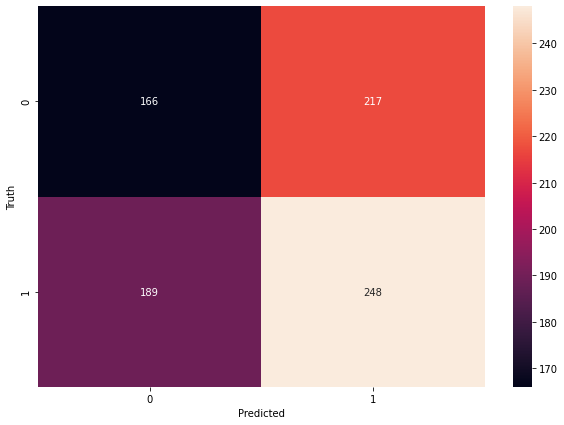

In [35]:
cm = tf.math.confusion_matrix(y_test, y_predicted)

import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [36]:
(216+191)/(216+191+231+182)

0.49634146341463414